In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, Activation
import numpy as np
import matplotlib.pyplot as plt
import cv2

2024-11-26 09:34:04.524043: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. This error is frequently encountered on macOS when running an x86 Python installation on ARM hardware. In this case, try installing an ARM build of Python. Otherwise, you may be able work around this issue by building jaxlib from source.

In [ ]:
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


x_train shape: (50000, 32, 32, 3), x_test shape: (10000, 32, 32, 3)


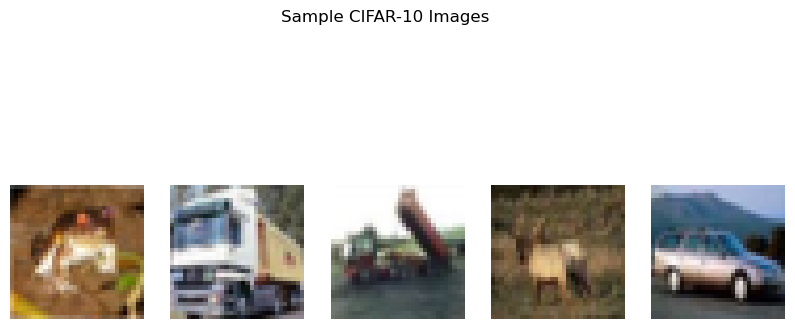

In [ ]:
def load_imagenet_sample():
    """
    ImageNet 샘플 데이터를 로드합니다.
    """
    (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train / 255.0  # 정규화
    x_test = x_test / 255.0
    return x_train, x_test

x_train, x_test = load_imagenet_sample()

# 데이터 확인
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.suptitle("Sample CIFAR-10 Images")
plt.show()

x_train shape: (60000, 28, 28, 1), x_test shape: (10000, 28, 28, 1)


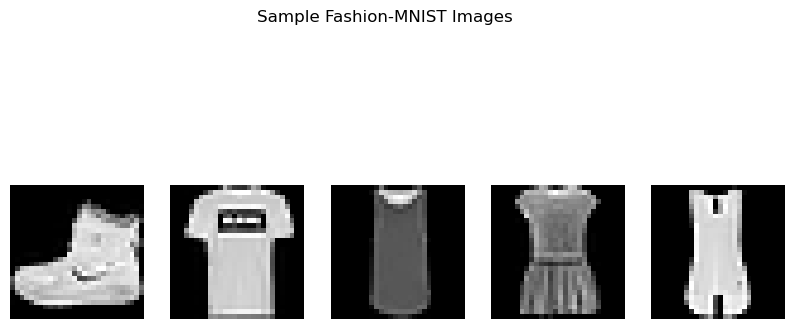

In [ ]:
def load_fashion_mnist():
    """
    Fashion-MNIST 데이터를 로드합니다.
    """
    (x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1) / 255.0  # 정규화 및 채널 추가
    x_test = np.expand_dims(x_test, axis=-1) / 255.0
    return x_train, x_test

x_train_fashion, x_test_fashion = load_fashion_mnist()

# 데이터 확인
print(f"x_train shape: {x_train_fashion.shape}, x_test shape: {x_test_fashion.shape}")
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train_fashion[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Fashion-MNIST Images")
plt.show()


x_train_low shape: (50000, 32, 32, 3), x_test_low shape: (10000, 32, 32, 3)


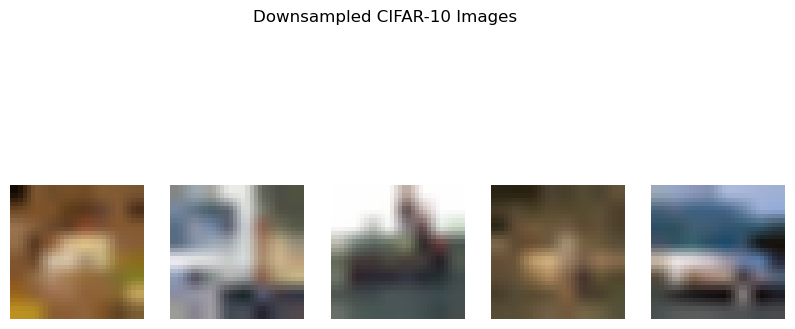

In [ ]:

# 데이터 전처리
def downsample_images(images, scale=4):
    """
    이미지를 다운샘플링합니다.
    """
    low_res_images = []
    for img in images:
        low_res = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale))
        low_res = cv2.resize(low_res, (img.shape[1], img.shape[0]))
        low_res_images.append(low_res)
    return np.array(low_res_images)

# CIFAR-10 데이터 다운샘플링
x_train_low_res = downsample_images(x_train)
x_test_low_res = downsample_images(x_test)

print(f"x_train_low shape: {x_train_low_res.shape}, x_test_low shape: {x_test_low_res.shape}")

# 다운샘플링 결과 확인
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train_low_res[i])
    plt.axis('off')
plt.suptitle("Downsampled CIFAR-10 Images")
plt.show()


In [ ]:
def build_espcn(input_shape):
    """
    일반 CNN
    """
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'))  # 출력 크기 동일
    return model

# 모델 생성
input_shape = x_train_low_res.shape[1:]  # (32, 32, 3)
model = build_espcn(input_shape)
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-11-25 18:28:15.986273: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 18:28:15.986980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 18:28:15.987545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 3)         867       
                                                                 
Total params: 61,123
Trainable params: 61,123
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 학습
# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 학습
history = model.fit(x_train_low_res, x_train, 
                    epochs=10, 
                    batch_size=16, 
                    validation_split=0.1)

Epoch 1/10


In [ ]:
# 모델 저장
model.save("./cnn_model.h5")
print("Model saved as 'cnn_model.h5'")

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, Activation
import tensorflow as tf

def subpixel_conv2d(scale):
    """
    Sub-pixel convolution layer for upscaling
    """
    return lambda x: tf.nn.depth_to_space(x, scale)

def build_espcn(input_shape, scale):
    """
    Efficient Sub-Pixel Convolutional Network 생성
    """
    model = Sequential()
    
    # 기본 CNN 레이어
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    
    # Sub-pixel 준비를 위한 컨볼루션 레이어 (채널 수 = scale^2 * output_channels)
    model.add(Conv2D(3 * (scale ** 2), (3, 3), padding='same', activation='relu'))
    
    # Sub-pixel convolution (Pixel Shuffle)
    model.add(Lambda(subpixel_conv2d(scale)))
    
    # 출력 레이어 (클램핑 또는 활성화)
    model.add(Conv2D(3, (3, 3), padding='same', activation='sigmoid'))  # 최종 RGB 출력
    
    return model

# 입력 데이터 모양과 업스케일링 스케일 설정
input_shape = (32, 32, 3)  # 저해상도 입력
scale = 2  # 업스케일링 배율

# 모델 생성
model = build_espcn(input_shape, scale)
model.summary()

In [ ]:
# 학습 결과 시각화
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [ ]:
# 테스트
x_test_fashion_low_res = downsample_images(x_test_fashion, scale=4)
x_test_sr = model.predict(x_test_fashion_low_res)

# 결과 시각화
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test_fashion_low_res[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(3, 5, i + 6)
    plt.imshow(x_test_fashion[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(3, 5, i + 11)
    plt.imshow(x_test_sr[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
